In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from network import *
from data import *
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math

print("Loading : ")
data = load_data('2019', 'BTCUSDT')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading : 
done


In [4]:
batch_size = 25
n_variables_past_contiuous = 4
n_variables_future_contiuous = 0
n_variables_past_discrete = [24, 31, 12]
n_variables_future_discrete = [24, 31, 12]


dim_model = 34
n_lstm_layers = 3
n_attention_layers = 3
n_heads = 6

quantiles = torch.tensor([0.5]).float().type(torch.cuda.FloatTensor)

#try:
t = TFN(n_variables_past_contiuous, n_variables_future_contiuous, 
            n_variables_past_discrete, n_variables_future_discrete, dim_model,
            n_quantiles = quantiles.shape[0], dropout_r = 0.1,
            n_attention_layers = n_attention_layers,n_lstm_layers = n_lstm_layers, n_heads = n_heads).cuda()

optimizer = torch.optim.Adam(t.parameters(), lr=0.002)

path = "model.bruh"

load_model = False

try:
    if(not load_model):
        raise Exception
    checkpoint = torch.load(path)
    t.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    print("Loaded model from checkpoint")
except:    
    print("No checkpoint found, initialising model")


losses = []

No checkpoint found, initialising model


<IPython.core.display.Javascript object>


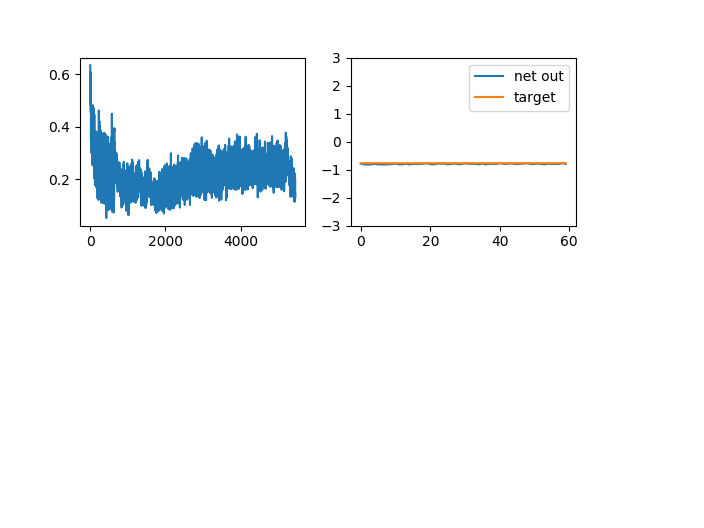

In [ ]:
past_seq_len = 60
future_seq_len = 60

fig = plt.figure()
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

#ax1.set_ylim([0,1])
plt.ion()

fig.show()
fig.canvas.draw()

g = get_batches(data, in_seq_len = past_seq_len, out_seq_len = future_seq_len, batch_size = batch_size)

b = False
for e in range(4000):
    for i in t.parameters():
        if(torch.isnan(i).any()):
            b = True
            
    if(b):
        break
    
    #reset gradients and hidden states
    t.reset(batch_size, gpu = True)
    optimizer.zero_grad()
    
    #get batch data
    in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq  = next(g)
    in_seq_discrete = one_hot(in_seq_discrete, [24 ,31 ,12])
    future_in_seq_discrete = one_hot(future_in_seq_discrete, [24 ,31 ,12])
    
    #forward pass and calculate loss
    net_out = t(in_seq_continuous, in_seq_discrete, None,  future_in_seq_discrete)
    loss = torch.mean(QuantileLoss(net_out, target_seq ,quantiles))
    
    if(torch.isnan(loss).any()):
        break
    
    #save model every 50 batches
    if(e % 50 == 0):
        torch.save({'model_state' : t.state_dict(), 'optimizer_state': optimizer.state_dict()} , "model.bruh")

    #backwards pass
    losses.append(loss)
    loss.backward()
    optimizer.step()
    
    #draw loss and comparison graphs
    ax1.clear()
    ax1.set_ylim([-3, 3])
    ax1.plot(net_out.cpu().detach().numpy()[0], label = "network output")
    ax1.plot(target_seq.cpu().detach().numpy()[0], label = "target")
    ax1.legend(loc=1)
    
    ax.clear()
    ax.plot(losses)

    fig.canvas.draw()

#print(torch.sum(torch.abs(net_out - y)))
#print(loss)
#print(net_out.shape)

In [ ]:
print(torch.isnan(in_seq_continuous).any())
#print(target_seq)

In [ ]:
torch.tensor((data[0]/0).values)

In [ ]:
import math
print(np.log(math.e))